In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
!wget https://github.com/mohammadsanaee/LSTM_spot_price/raw/main/df_daily.csv
df = pd.read_csv('df_daily.csv')

--2023-05-23 05:34:47--  https://github.com/mohammadsanaee/LSTM_spot_price/raw/main/df_daily.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mohammadsanaee/LSTM_spot_price/main/df_daily.csv [following]
--2023-05-23 05:34:47--  https://raw.githubusercontent.com/mohammadsanaee/LSTM_spot_price/main/df_daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 718637 (702K) [text/plain]
Saving to: ‘df_daily.csv.1’

df_daily.csv.1      100%[===================>] 701.79K  --.-KB/s    in 0.04s   

2023-05-23 05:34:47 (15.9 MB/s) - ‘df_daily.csv.1’ saved [718637/718637]



In [ ]:
df.head()

,date,price_pesos,exchange,price_usd,gas_price,coal_price,gas_rate,coal_rate,log_price
0,2006-06-26,3696.799565,53.4002,69.228197,7.1,2.100882,9.750450,32.951961,3.426412
1,2006-06-27,4494.720000,53.4750,84.052735,7.1,2.100882,11.838413,40.008299,NaN
2,2006-06-28,3419.524583,53.5800,63.820914,7.1,2.100882,8.988861,30.378146,3.471716
3,2006-06-29,2904.085417,53.5502,54.231084,7.1,2.100882,7.638181,25.813478,3.346610
4,2006-06-30,4178.192500,53.1102,78.670246,7.1,2.100882,11.080316,37.446286,3.480780


In [ ]:
df=df.loc[(df['date'] >= '2015-01-01')]


In [ ]:
df1=df.reset_index()['price_pesos']

In [ ]:
df1

0       2082.394527
1       2018.771891
2       1512.324746
3       2109.936419
4       4703.001446
           ...     
2263    3346.681250
2264    3571.285000
2265    2314.728333
2266    2299.245000
2267    1922.081304
Name: price_pesos, Length: 2268, dtype: float64

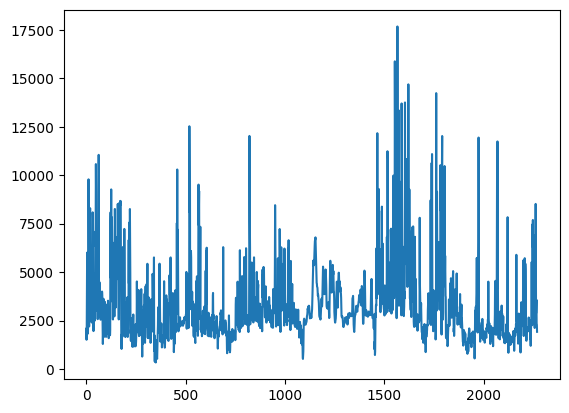

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_df=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
training_size=int(len(scaled_df)*0.85)
test_size=len(scaled_df)-training_size
train_data,test_data=scaled_df[0:training_size,:],scaled_df[training_size:len(scaled_df),:1]

In [ ]:
training_size,test_size

(1927, 341)

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
y_train


array([0.07613672, 0.15013488, 0.11982514, ..., 0.08018151, 0.08742913,
       0.09286914])

In [ ]:
print(X_train.shape), print(y_train.shape)

(1826, 100)
(1826,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(240, 100)
(240,)


(None, None)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
print(X_train.shape), print(X_test.shape)

(1826, 100, 1)
(240, 100, 1)


(None, None)

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history  = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

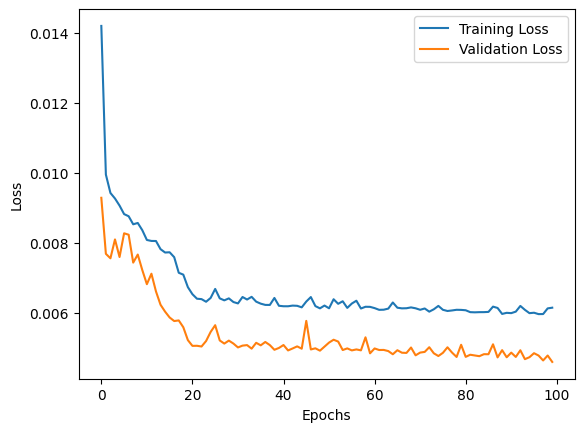

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss = model.evaluate(X_test, ytest)

print("Test Loss:", loss)

8/8 [==============================] - 0s 7ms/step - loss: 0.0046
Test Loss: 0.004603350069373846


In [ ]:
# ytest

In [ ]:
y_true = scaler.inverse_transform(ytest.reshape(-1, 1))


In [ ]:
# y_true

In [ ]:
from sklearn.metrics import mean_absolute_error

scaled_y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(scaled_y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(mae)

8/8 [==============================] - 0s 10ms/step
681.2178821138565


In [ ]:
train_predict=model.predict(X_train)

58/58 [==============================] - 0s 7ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: ignored

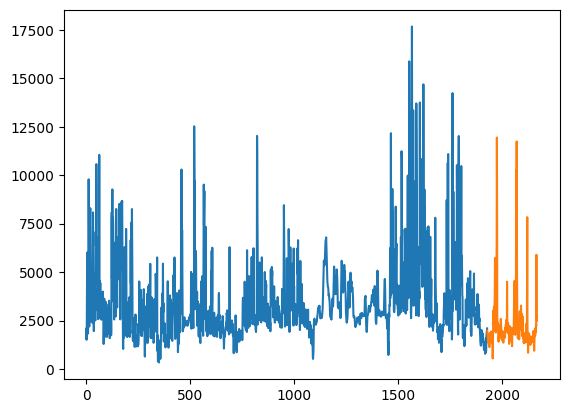

In [ ]:
import matplotlib.pyplot as plt

# Plotting train data
plt.plot(scaler.inverse_transform(train_data), label='Train Data')

# Plotting test data
test_start_index = training_size 
test_end_index = test_start_index + len(ytest)
test_indices = range(test_start_index, test_end_index)
test_data_unscaled = scaler.inverse_transform(test_data[:len(ytest)])
plt.plot(test_indices, test_data_unscaled, label='Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


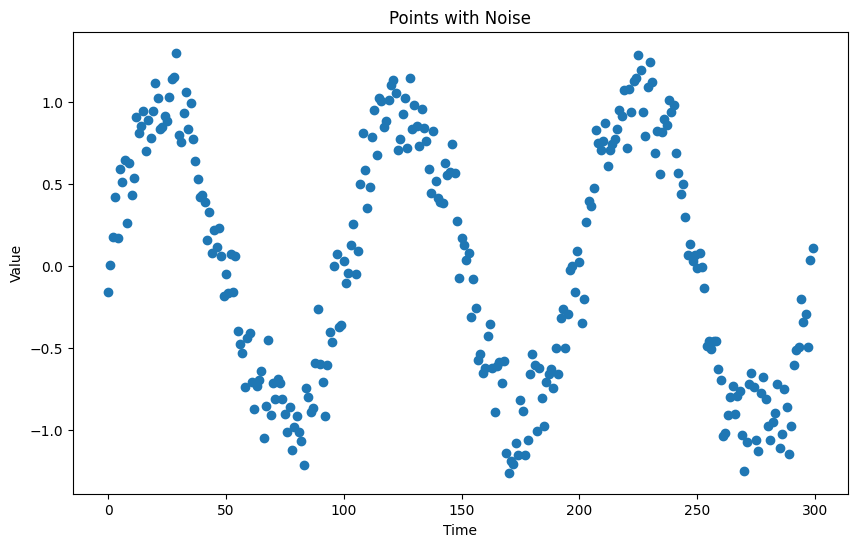

In [54]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt

def generate_points(n_points, amplitude, frequency, ar_order, ar_params, noise_scale):
    # Generate sinusoidal points
    time = np.arange(n_points)
    points = amplitude * np.sin(2 * np.pi * frequency * time / n_points)
    
    # Generate autoregressive noise
    ar_process = ArmaProcess(ar_params, [1])
    noise = ar_process.generate_sample(n_points) * noise_scale
    
    # Add noise to the points
    points_with_noise = points + noise
    
    return points_with_noise

# Parameters
n_points = 300  # Number of points
amplitude = 1.0  # Amplitude of the sinusoidal function
frequency = 3# Frequency of the sinusoidal function
ar_order = 2     # Order of the autoregressive model
ar_params = [0.5, -0.2]  # Coefficients of the autoregressive model
noise_scale = 0.08  # Scaling factor for the noise

train_points = generate_points(n_points, amplitude, frequency, ar_order, ar_params, noise_scale)

plt.figure(figsize=(10, 6))
plt.plot(train_points,'o')
plt.title("Points with Noise")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


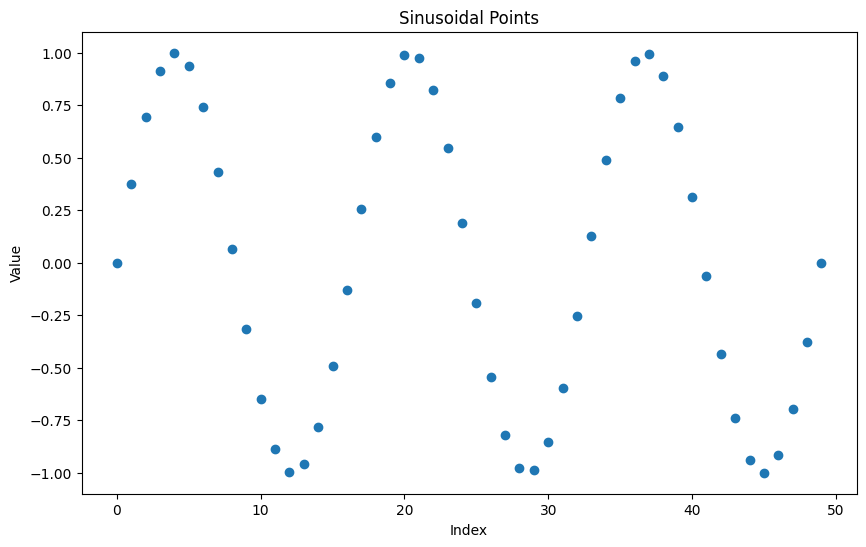

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(n_points, amplitude, frequency):
    time = np.linspace(0, 2*np.pi, n_points)
    points = amplitude * np.sin(frequency * time)
    return points

# Parameters
n_points = 50  # Number of points
amplitude = 1.0  # Amplitude of the sinusoidal function
frequency = 3.0  # Frequency of the sinusoidal function

# Generate points
test_points = generate_points(n_points, amplitude, frequency)

# Plot the points
plt.figure(figsize=(10, 6))
plt.plot(test_points,'o')
plt.title("Sinusoidal Points")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


In [26]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
indexed_train = np.array(list(enumerate(train_points)))
indexed_test = np.array(list(enumerate(test_points)))

In [59]:
indexed_test[:,0]=indexed_test[:,0].astype(int)

In [66]:
type(indexed_test[0,0])

numpy.float64

In [41]:
time_step = 10
X_train, y_train = create_dataset(indexed_train, time_step)
X_test, ytest = create_dataset(indexed_test, time_step)

In [42]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [52]:
X_train.shape

(289, 10, 1)

In [49]:
history  = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

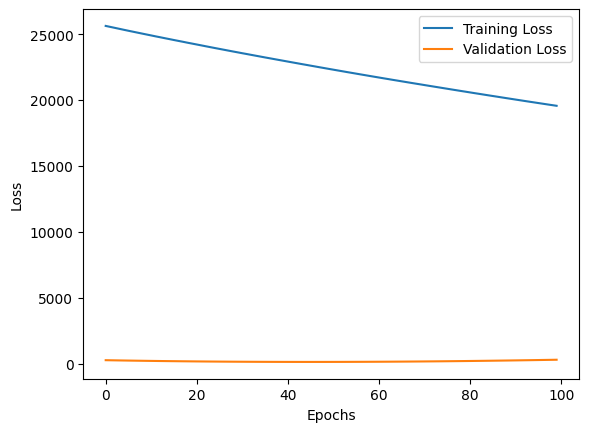

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<300):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,401)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

2268

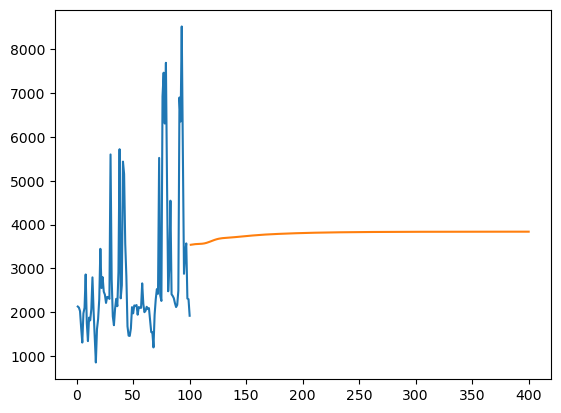

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[2168:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

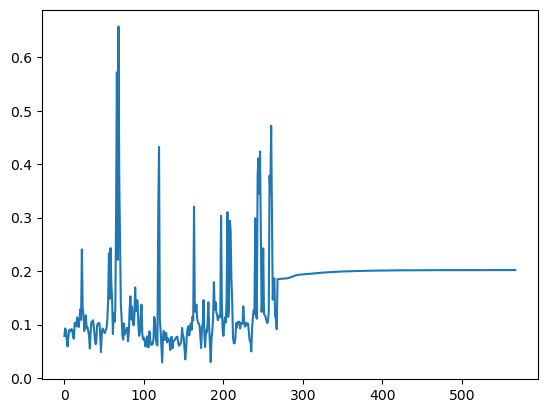

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

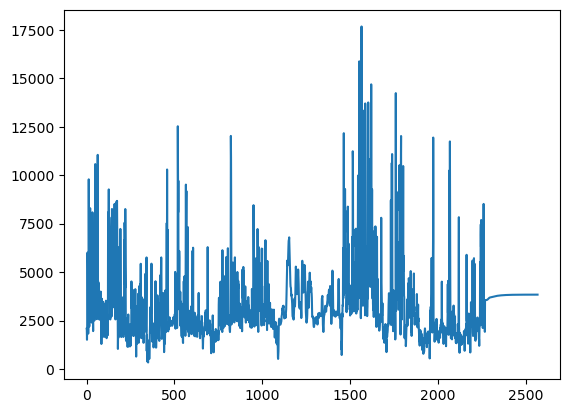

In [ ]:
plt.plot(df3)